In [5]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [2]:
# Importar las bibliotecas necesarias
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from nltk.corpus import stopwords

# Cargar el archivo de datos
file_path = "Noticias.xlsx"
data = pd.read_excel(file_path)

# Mostrar una vista previa de los datos
data.head()

,Columna1,Enlaces,Título,info,contenido,Etiqueta
0,0,https://www.eltiempo.com/agresion-contra-un-op...,Operador de grúa quedó inconsciente tras agres...,El conductor de una moto le lanzó el casco y p...,Las autoridades están buscando al conductor de...,colombia
1,1,https://www.eltiempo.com/archivo/documento/CMS...,"Usaquén, primera en infracciones por mal parqueo",La localidad ocupa el primer lugar en comparen...,"""Los andenes son para los peatones"", reclama e...",archivo
2,2,https://www.eltiempo.com/archivo/documento/CMS...,'Me atracaron y vi un arma que me heló la sang...,Un ciudadano relata cómo cuatro hombres lo rob...,A las 7 de la noche me había quedado de encont...,archivo
3,3,https://www.eltiempo.com/archivo/documento/CMS...,"Escoltas mal estacionados, dolor de cabeza de ...",Las zonas de restaurantes se convierten en par...,Atravesados. Eso es lo que se les pasa por la ...,archivo
4,4,https://www.eltiempo.com/archivo/documento/CMS...,Radicado primer proyecto que autorizaría union...,"El representante de 'la U', Miguel Gómez, dijo...",“Estamos proponiendo la figura de un contrato ...,archivo


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# Filtrar las categorías relevantes y excluir "archivo"
categorias_relevantes = ['deportes', 'cultura', 'economia', 'justicia']
data = data[data['Etiqueta'].isin(categorias_relevantes)]

In [4]:
# Función para preprocesar texto
def preprocess_text(text):
    """
    Esta función realiza el preprocesamiento del texto.
    1. Convierte el texto a minúsculas.
    2. Elimina la puntuación.
    3. Elimina los números.
    4. Elimina los espacios en blanco adicionales.

    Parámetros:
    text (str): El texto original.

    Retorna:
    str: El texto preprocesado.
    """
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Eliminar números
    text = re.sub(r'\d+', '', text)
    # Eliminar espacios en blanco adicionales
    text = text.strip()
    return text

# Aplicar preprocesamiento al contenido
## Deben eliminarse los valores nulos antes de aplicar el preprocesamiento
data = data.dropna(subset=['contenido'])

# Aplicar preprocesamiento al contenido
data['contenido_preprocesado'] = data['contenido'].apply(preprocess_text)

# Mostrar una vista previa de los datos preprocesados
display(data[['contenido', 'contenido_preprocesado']].head())

# Dimensiones de los datos

print(f'Dimensiones de los datos: {data.shape}')

,contenido,contenido_preprocesado
10487,Citas: “Los crímenes de violencia sexual comet...,citas “los crímenes de violencia sexual cometi...
10488,Con motivo de la celebración de los 20 años de...,con motivo de la celebración de los años de l...
10489,"El cuadro Busto de mujer, del artista español ...",el cuadro busto de mujer del artista español p...
10490,"El Carnaval de las Artes, organizado en Barran...",el carnaval de las artes organizado en barranq...
10491,"Louise du Toit, filósofa; el doctor Denis Mukw...",louise du toit filósofa el doctor denis mukweg...


Dimensiones de los datos: (1866, 7)


In [6]:
# Tokenización
data['tokens'] = data['contenido_preprocesado'].apply(word_tokenize)

# Mostrar una vista previa de los tokens
data[['contenido_preprocesado', 'tokens']].head()

,contenido_preprocesado,tokens
10487,citas “los crímenes de violencia sexual cometi...,"[citas, “, los, crímenes, de, violencia, sexua..."
10488,con motivo de la celebración de los años de l...,"[con, motivo, de, la, celebración, de, los, añ..."
10489,el cuadro busto de mujer del artista español p...,"[el, cuadro, busto, de, mujer, del, artista, e..."
10490,el carnaval de las artes organizado en barranq...,"[el, carnaval, de, las, artes, organizado, en,..."
10491,louise du toit filósofa el doctor denis mukweg...,"[louise, du, toit, filósofa, el, doctor, denis..."


In [9]:
## Revise los tokens para asegurarse de que el texto se haya tokenizado correctamente

print("Contenido preprocesado: ", data['contenido_preprocesado'][10488])
print("Tokens: ", data['tokens'][10488])

Contenido preprocesado:  con motivo de la celebración de los  años de la enseñanza de la danza oriental en colombia llega dakini danzarina de luz un festival mágico que trae lo mejor de la danza de oriente este espectáculo que honra el espíritu femenino contará con más de  bailarinas en escena y pondrá a bailar a bogotá con ritmos de la india y egipto antonina canal sanadora holística conferencista bailarina empresaria y madre habló con el tiempo acerca de su trayectoria en la enseñanza de la sabiduría de la danza y de su ‘show’ dakini que interpretará con óscar flores que fue nombrado el ‘príncipe de la danza’ a nivel mundial y dariya mitskevich la figura más importante de la danza oriental en el mundo ¿cuándo nació el interés por los temas esotéricos y espirituales hace  años cuando fui a la india allá estudié yoga meditación y luego pasé a vivir a egipto también hice un recorrido por turquía marruecos y aprendí toda la sabiduría de la danza la gente piensa que la danza árabe es un b

In [10]:
 # Eliminar stop words
stop_words = set(stopwords.words('spanish'))
data['tokens_sin_stopwords'] = data['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Mostrar una vista previa de los tokens sin stop words
data[['tokens', 'tokens_sin_stopwords']].head()

,tokens,tokens_sin_stopwords
10487,"[citas, “, los, crímenes, de, violencia, sexua...","[citas, “, crímenes, violencia, sexual, cometi..."
10488,"[con, motivo, de, la, celebración, de, los, añ...","[motivo, celebración, años, enseñanza, danza, ..."
10489,"[el, cuadro, busto, de, mujer, del, artista, e...","[cuadro, busto, mujer, artista, español, pablo..."
10490,"[el, carnaval, de, las, artes, organizado, en,...","[carnaval, artes, organizado, barranquilla, fu..."
10491,"[louise, du, toit, filósofa, el, doctor, denis...","[louise, du, toit, filósofa, doctor, denis, mu..."


In [11]:
# Unir los tokens en una sola cadena de texto para cada documento
data['texto_sin_stopwords'] = data['tokens_sin_stopwords'].apply(lambda tokens: ' '.join(tokens))
data['texto_sin_stopwords'].index=range(0,len(data['texto_sin_stopwords']))

# Calcular TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['texto_sin_stopwords'])

# Convertir la matriz TF-IDF a un DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Mostrar una vista previa de la matriz TF-IDF
tfidf_df.head()

,aa,aaa,aac,aage,aarhus,aaron,ab,aba,abad,abadía,...,único,únicos,úrsula,úselo,úsuga,útero,útil,útiles,ünal,şükran
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
tfidf_df

,aa,aaa,aac,aage,aarhus,aaron,ab,aba,abad,abadía,...,único,únicos,úrsula,úselo,úsuga,útero,útil,útiles,ünal,şükran
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Información adicional
data['contenido_preprocesado'].index=range(0,len(data['contenido_preprocesado']))
lista_contenido= data['contenido_preprocesado'][0].split()
# Incluimos \n cada 15 palabras para mejorar la legibilidad

lista_contenido= [f"{word} " if (i+1)%15!=0 else f"{word}\n" for i, word in enumerate(lista_contenido)]

## Ahora convertimos la lista en un string

contenido= ''.join(lista_contenido)

text_info= f"""En este ejemplo particular tomamos el contenido:

{contenido}

Y lo convertimos en un vector TF-IDF de {tfidf_df.shape[1]} dimensiones:

{tfidf_df.iloc[0]}.


Acabamos de convertir un documento de texto en un vector numérico que puede ser
utilizado en algoritmos de aprendizaje automático. Ese vector representa la importancia
de cada palabra en el documento original y nos permite usar por ejemplo:

- ACP para reducir la dimensionalidad del vector.
- Clustering para agrupar documentos similares.
- Clasificación para predecir la categoría de un documento.
- Recuperación de información para encontrar documentos similares.

"""

print(text_info)



En este ejemplo particular tomamos el contenido:

citas “los crímenes de violencia sexual cometidos al interior de un grupo armado” la silla
vacía “confirman que periodista saudí murió tras riña al interior de consulado en estambul” an
“menor de edad intentó suicidarse al interior de su casa” ondas de ibagué tres casos
en los que “al interior de” no es otra cosa que el reemplazo sofisticado e
innecesario de la simple preposición “en” “… en un grupo armado” “… murió en el
consulado…” “… intentó suicidarse en su casa” se trata de un galicismo introducido al país
por los violentólogos de la sorbona “al interior de” es válido solo con verbos de
movimiento “después de recorrer la costa atlántica se dirigió al interior del país” nótese cómo
este “al interior de” es necesario para el significado y no puede reemplazarse por “en”
¡ese es el uso correcto citas “ahora consigo ganar dólares por semana a parte de
mi salario” aviso “estudio en la javeriana por las oportunidades que me da para involu

In [15]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Reducir dimensionalidad con SVD para explorar cuántos componentes son óptimos
num_components = 1500  # Puedes probar hasta 50 componentes u otros valores
svd = TruncatedSVD(n_components=num_components, random_state=42)

# Ajustar SVD
svd.fit(tfidf_df)
total_varianza_explicada = svd.explained_variance_ratio_.sum()
reduced_features = svd.fit_transform(tfidf_df)  # Reducir las dimensiones


In [16]:
total_varianza_explicada

0.9265607353600784

In [17]:
reduced_features

array([[ 1.20084114e-01, -2.98264458e-02, -9.85194150e-03, ...,
         4.19806321e-03,  4.09092821e-03,  5.03483268e-03],
       [ 8.44479765e-02, -6.14818139e-02, -1.01631927e-02, ...,
        -7.88827185e-03,  1.53083645e-03,  2.28483490e-02],
       [ 1.47165322e-01, -3.66135345e-02, -2.58403680e-02, ...,
         8.63167757e-03, -4.95566805e-03,  9.00420959e-03],
       ...,
       [ 1.38798307e-01, -1.22795854e-01, -3.53022149e-02, ...,
        -1.39139735e-04,  6.02374367e-03,  2.03865565e-02],
       [ 1.61639250e-01, -4.58091777e-02, -5.92482662e-02, ...,
        -1.62654282e-02,  5.91140833e-03, -1.42888237e-02],
       [ 1.68663422e-01,  9.40332230e-04, -4.67552109e-02, ...,
         3.72032940e-04, -3.75185503e-03,  1.86173180e-02]])

In [19]:
feature_names = tfidf_df.columns

best_features = [feature_names[i] for i in svd.components_[0].argsort()[::-1]]

new_df = pd.DataFrame(reduced_features,columns=best_features[:1500])
new_df.head()

,pm,colombia,valle,manizales,vida,salud,coronavirus,casos,cerca,posible,...,propia,vicepresidente,vino,directora,tranquilidad,evolución,capturado,programas,vehículos,múnich
0,0.120084,-0.029826,-0.009852,-0.007742,-0.046612,-0.031714,0.021282,0.019596,0.012787,0.019450,...,0.005160,-0.011701,-0.016473,0.002403,-0.008025,-0.024810,0.024988,0.004198,0.004091,0.005035
1,0.084448,-0.061482,-0.010163,0.008362,-0.072365,-0.049102,0.065738,-0.003129,0.026099,-0.003425,...,-0.008617,0.000723,-0.011244,0.005156,0.007526,-0.009173,-0.005500,-0.007888,0.001531,0.022848
2,0.147165,-0.036614,-0.025840,0.005924,-0.042591,-0.027069,0.020826,-0.004755,-0.028370,0.056304,...,0.002594,0.003182,0.011530,0.011123,-0.004620,-0.007537,0.001258,0.008632,-0.004956,0.009004
3,0.185286,0.024762,-0.022188,-0.005473,-0.057282,-0.050627,0.084975,0.015439,0.009341,0.051071,...,-0.001003,0.001743,0.000215,-0.013642,-0.008233,-0.001076,-0.008698,0.013146,-0.022308,0.008741
4,0.137961,-0.030625,-0.025307,0.008911,-0.092991,0.037121,0.013159,0.002727,0.127703,-0.019628,...,-0.013829,0.022281,0.004321,-0.024264,0.019581,0.009430,-0.002135,-0.013988,0.002622,0.029439


In [24]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# Ajustar KMeans con las características reducidas
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(new_df)
new_df['Cluster'] = kmeans.labels_


In [25]:
new_df

,pm,colombia,valle,manizales,vida,salud,coronavirus,casos,cerca,posible,...,vicepresidente,vino,directora,tranquilidad,evolución,capturado,programas,vehículos,múnich,Cluster
0,0.120084,-0.029826,-0.009852,-0.007742,-0.046612,-0.031714,0.021282,0.019596,0.012787,0.019450,...,-0.011701,-0.016473,0.002403,-0.008025,-0.024810,0.024988,0.004198,0.004091,0.005035,1
1,0.084448,-0.061482,-0.010163,0.008362,-0.072365,-0.049102,0.065738,-0.003129,0.026099,-0.003425,...,0.000723,-0.011244,0.005156,0.007526,-0.009173,-0.005500,-0.007888,0.001531,0.022848,1
2,0.147165,-0.036614,-0.025840,0.005924,-0.042591,-0.027069,0.020826,-0.004755,-0.028370,0.056304,...,0.003182,0.011530,0.011123,-0.004620,-0.007537,0.001258,0.008632,-0.004956,0.009004,1
3,0.185286,0.024762,-0.022188,-0.005473,-0.057282,-0.050627,0.084975,0.015439,0.009341,0.051071,...,0.001743,0.000215,-0.013642,-0.008233,-0.001076,-0.008698,0.013146,-0.022308,0.008741,1
4,0.137961,-0.030625,-0.025307,0.008911,-0.092991,0.037121,0.013159,0.002727,0.127703,-0.019628,...,0.022281,0.004321,-0.024264,0.019581,0.009430,-0.002135,-0.013988,0.002622,0.029439,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,0.177507,-0.059041,-0.043594,0.037918,-0.040657,0.129768,-0.010502,0.020754,0.042895,-0.042607,...,0.019410,-0.020210,0.009529,0.016698,0.008464,-0.017800,-0.017155,-0.013503,0.050209,1
1862,0.170380,-0.123938,-0.051930,0.051470,-0.073103,0.117904,-0.042892,-0.016329,-0.051175,-0.018099,...,0.025578,-0.010899,-0.032063,-0.006288,0.008745,-0.004148,0.043049,0.004807,0.009295,1
1863,0.138798,-0.122796,-0.035302,0.034099,-0.083197,0.006081,0.011673,-0.021950,-0.040203,-0.046310,...,0.007362,-0.005863,0.021249,-0.022714,-0.008747,-0.013141,-0.000139,0.006024,0.020387,1
1864,0.161639,-0.045809,-0.059248,0.051389,-0.017213,0.043344,-0.001035,-0.006095,-0.004691,-0.016172,...,0.004451,-0.012492,0.017828,-0.001964,0.010245,-0.018968,-0.016265,0.005911,-0.014289,1


In [26]:
# Contar el tamaño de cada cluster
cluster_counts = new_df['Cluster'].value_counts()
print("Tamaño de cada cluster:\n", cluster_counts)

Tamaño de cada cluster:
 Cluster
1    1289
0     408
4      74
3      70
2      25
Name: count, dtype: int64


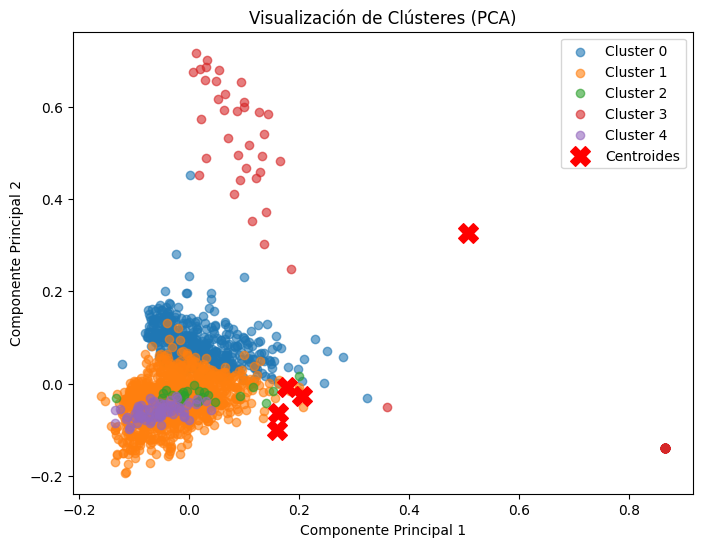

Índice de Silueta Promedio: -0.006


In [27]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Reducir los datos a 2D usando PCA
pca = PCA(n_components=2)
data_2d = pca.fit_transform(new_df.drop('Cluster', axis=1, errors='ignore'))  # Aseguramos que 'Cluster' no esté al reducir dimensiones

# Graficar los clústeres
plt.figure(figsize=(8, 6))
for cluster in range(5):  # Asumimos 5 clústeres
    cluster_data = data_2d[new_df['Cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', alpha=0.6)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='red', marker='X', s=200, label='Centroides')
plt.title('Visualización de Clústeres (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.show()

# Calcular el índice de silueta
silhouette_avg = silhouette_score(new_df.drop('Cluster', axis=1, errors='ignore'), new_df['Cluster'])
print(f"Índice de Silueta Promedio: {silhouette_avg:.3f}")


In [30]:
# Conclusión: los clusters no son significativos pues se puede notar un solapamiento entre ellos. Los datos no presentan una separación clara entre grupos, lo que dificulta que el algoritmo encuentre fronteras definidas.

## Paso 5: Generación de Embeddings de Palabras con Word2Vec

En este paso, utilizaremos el modelo Word2Vec para generar embeddings de palabras. Los embeddings de palabras son representaciones vectoriales densas que capturan el significado semántico de las palabras.

In [31]:
# Entrenar el modelo Word2Vec
word2vec_model = Word2Vec(sentences=data['tokens_sin_stopwords'], vector_size=100, window=5, min_count=1, workers=4)

# Obtener los embeddings de una palabra ejemplo
word_example = 'noticia'
if word_example in word2vec_model.wv:
    embedding_example = word2vec_model.wv[word_example]
    print(f'Embedding de la palabra "{word_example}":\n{embedding_example}')
else:
    print(f'La palabra "{word_example}" no está en el vocabulario del modelo Word2Vec.')

# Guardar el modelo Word2Vec
word2vec_model.save("word2vec.model")

Embedding de la palabra "noticia":
[-5.61627388e-01  2.12234244e-01 -2.45931789e-01  1.09154433e-02
  2.65574008e-01 -2.77384579e-01  2.76396245e-01  4.00862217e-01
 -3.42904866e-01  3.75560343e-01 -6.39600515e-01 -5.41687071e-01
 -6.03027821e-01 -8.35318193e-02  1.60386696e-01 -5.07224977e-01
 -1.66900396e-01 -5.23370743e-01  6.13821186e-02 -3.68136734e-01
 -1.55155063e-01 -1.56593882e-02 -3.48344028e-01  2.81073511e-01
 -2.00362578e-02 -2.04224542e-01 -3.85585964e-01 -2.22935855e-01
 -3.85058612e-01 -4.56479117e-02  2.88802564e-01  4.87680733e-02
 -3.99217665e-01 -3.37331854e-02  1.65706798e-01  1.47069320e-01
  2.81038821e-01 -1.14646815e-01  6.50559127e-01 -4.17067975e-01
  6.45059347e-01 -3.23028654e-01 -1.40611902e-01 -3.50819007e-02
  2.23441005e-01  2.24648878e-01 -1.68075755e-01  6.79565966e-01
  1.32174522e-01 -4.72999905e-04  2.64304280e-01 -7.51300827e-02
  7.71359622e-01  1.54077247e-01 -3.36642593e-01  1.45009071e-01
  8.21109116e-02 -1.83210924e-01 -4.60898370e-01  3.736

In [62]:
word2vec_model = Word2Vec.load("word2vec.model")

# Obtener embeddings y vocabulario
word_vectors = word2vec_model.wv
vocab_words = list(word_vectors.index_to_key)  # Lista de palabras en el vocabulario
word_embeddings = np.array([word_vectors[word] for word in vocab_words])  # Matriz de embeddings

# Aplicar SVD para reducir la dimensionalidad
n_components = 50  # Puedes elegir la cantidad de dimensiones a reducir
svd = TruncatedSVD(n_components=n_components, random_state=42)
reduced_embeddings = svd.fit_transform(word_embeddings).astype(np.float64)

# Crear un diccionario para mapear las palabras a sus nuevos embeddings reducidos
word_mapping = {word: reduced_embeddings[i] for i, word in enumerate(vocab_words)}

# Ejemplo: acceder a un embedding reducido de una palabra
word_example = 'estudiante'
if word_example in word_mapping:
    print(f"Nuevo embedding reducido de '{word_example}':\n{word_mapping[word_example]}")
else:
    print(f"La palabra '{word_example}' no está en el vocabulario del modelo.")

Nuevo embedding reducido de 'estudiante':
[-1.59644914e+00 -5.93002513e-02  2.27091685e-02  1.60381347e-02
 -9.48043466e-02 -1.45747028e-02  6.69499636e-02  9.78824496e-03
  2.04081647e-02  5.31065185e-03  1.04108760e-02  1.24694696e-02
 -1.87547207e-02  1.81478867e-03  4.99876589e-03  2.62878579e-03
 -5.55991195e-03 -4.49808314e-03 -4.08423925e-03  5.98169444e-03
  1.72899116e-03 -7.69936619e-03  9.00039356e-03 -5.27849793e-03
 -6.20601838e-03  3.05462256e-03 -2.84422934e-03 -9.74170119e-03
 -2.39301845e-03  7.40617514e-04  9.88051761e-04  1.48897432e-03
  4.02322412e-03  6.64125336e-03 -2.87872250e-03 -1.73965353e-03
  9.42606851e-03 -1.02502881e-02  6.80080848e-04 -3.44273332e-03
  6.02111034e-03  8.36879853e-03  6.19770935e-06 -7.27712084e-03
  1.53520214e-03  2.48951581e-03 -2.22575013e-03  8.36048461e-03
  1.49766298e-03  8.31493828e-03]


In [63]:
# Crear el modelo KMeans para encontrar 5 clusters
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(reduced_embeddings)

# Mapear las palabras a sus respectivos clusters
clusters = {word: kmeans.predict([reduced_embeddings[i]])[0] for i, word in enumerate(vocab_words)}

# Mostrar los grupos de palabras por cluster
cluster_dict = {i: [] for i in range(n_clusters)}
for word, cluster_id in clusters.items():
    cluster_dict[cluster_id].append(word)

# Imprimir los grupos de palabras en cada cluster
for cluster_id, words in cluster_dict.items():
    print(f"\nCluster {cluster_id}:")
    print(words)


Cluster 0:
['eltiempocom', 'obligatoria', 'correcta', 'espiritual', 'reproducciones', 'latinoamericanos', 'nace', 'secretaría', 'termine', '°', 'discapacidad', 'europeas', 'ayudado', 'probar', 'youtuber', 'extensión', 'biblioteca', 'candelaria', 'streaming', 'lleras', 'defensoría', 'man', 'catar', 'acoso', 'aseo', 'migración', 'risaralda', 'capturadas', 'reintegración', 'aplazamiento', 'águila', 'cableoperador', 'higuita', 'evaluación', 'nombrado', 'baile', 'emprendedores', 'viable', 'erradicación', 'sabido', 'grados', 'emitido', 'popayán', 'estadios', 'luchando', 'anfitrión', 'uci', 'autorización', 'traslado', 'impone', 'reflexión', 'ganadora', 'activa', 'vulnerable', 'jugarán', 'liliana', 'prestar', 'guacho', 'gala', 'económicamente', 'carcelario', 'aportado', 'sábados', 'salga', 'dígitos', 'sl', 'sanabria', 'adiós', 'décimo', 'edades', 'gustaría', 'conocía', 'juanes', 'valdez', 'lamentablemente', 'consenso', 'cuestionó', 'donar', 'agresión', 'censo', 'ocurrieron', 'tristeza', 'lega

In [68]:
# Encontrar las palabras más similares utilizando el método most_similar
word_example = 'deportes'  # Cambiar la palabra según sea necesario

# Obtener las palabras más similares
similar_words = word2vec_model.wv.most_similar(word_example, topn=10)

# Imprimir los resultados
print(f"Palabras más similares a '{word_example}':")
for word, sim in similar_words:
    print(f"{word}: {sim:.4f}")

Palabras más similares a 'deportes':
miedo: 0.9755
efe: 0.9540
gabrielflorezg: 0.9416
twitter: 0.9333
justicia: 0.9186
lanacion: 0.9173
marquitosgarces: 0.9035
ejercite: 0.8995
ramonandressava: 0.8984
futbolred: 0.8969


In [69]:
silhouette_score(reduced_embeddings, labels)



0.7626002400140106

In [71]:
# Conclusión: Un indice de silueta de 0,76 demuestran que las muestras dentro de cada cluster están bien agrupadas entre sí, lo que significa que comparten características similares.

## Conlcusiones
Word2Vec es Semántico
Captura las relaciones semánticas de palabras en un espacio continuo. Por lo tanto, las palabras que comparten contexto o significado tienden a formar clusters más cohesivos y representativos.
📊 TF-IDF es Estadístico y Local
Se enfoca únicamente en la frecuencia y la relevancia de palabras en documentos individuales, lo que puede generar clusters basados en patrones estadísticos en lugar de relaciones semánticas. Esto puede resultar en clusters menos representativos.